In [1]:
import numpy as np
import matplotlib.pyplot as plt

Useful Funcs

In [ ]:
import numpy as np


def get_cov(sdx=1., sdy=1., rotangdeg=0.):
    covar = np.array([[sdx, 0], [0, sdy]])
    rot_ang = rotangdeg / 360 * 2 * np.pi
    rot_mat = np.array([[np.cos(rot_ang), -np.sin(rot_ang)], [np.sin(rot_ang), np.cos(rot_ang)]])

    covar = np.matmul(np.matmul(rot_mat, covar), rot_mat.transpose())
    return covar


def gen_circular_distribution(n=500, scale=1):
    a = np.round(n / 7).astype('int')
    b = np.round(2*n / 7).astype('int')
    c = n - a - b
    r1 = np.concatenate(
        [np.random.normal(loc=2, scale=scale, size=[a, 1]), np.random.normal(loc=8, scale=scale, size=[c, 1])])
    r2 = np.random.normal(loc=5, scale=scale, size=[b, 1])

    th1 = np.random.uniform(low=0, high=2 * np.pi, size=[a+c, 1])
    th2 = np.random.uniform(low=0, high=2 * np.pi, size=[b, 1])

    x1a = r1 * np.cos(th1)
    x2a = r1 * np.sin(th1)

    x1b = r2 * np.cos(th2)
    x2b = r2 * np.sin(th2)

    X = np.concatenate([np.concatenate([x1a.reshape([a+c, 1]), x1b.reshape([b, 1])]),
                        np.concatenate([x2a.reshape([a+c, 1]), x2b.reshape([b, 1])])], axis=1)

    y = np.concatenate([np.zeros([a+c, 1]), np.ones([b, 1])]).squeeze()
    return X, y


def gen_simple_circular_distribution(n=100, scale=1):
    a = np.round(n/3).astype('int')
    b = n-a
    r1 = np.random.normal(loc=0, scale=scale, size=[a, 1])
    r2 = np.random.normal(loc=5, scale=scale, size=[b, 1])

    th1 = np.random.uniform(low=0, high=2 * np.pi, size=[a, 1])
    th2 = np.random.uniform(low=0, high=2 * np.pi, size=[b, 1])

    x1a = r1 * np.cos(th1)
    x2a = r1 * np.sin(th1)

    x1b = r2 * np.cos(th2)
    x2b = r2 * np.sin(th2)

    X = np.concatenate([np.concatenate([x1a.reshape([a, 1]), x1b.reshape([b, 1])]),
                        np.concatenate([x2a.reshape([a, 1]), x2b.reshape([b, 1])])], axis=1)

    y = np.concatenate([np.zeros([a, 1]), np.ones([b, 1])]).squeeze()
    return X, y


def gen_xor_distribution(n=100):
    a = np.round(n / 4).astype('int')
    b = n-a*3
    xc1 = np.concatenate([np.random.multivariate_normal([-2.3, -2.3], get_cov(0.4, 0.1, -45), a),
                          np.random.multivariate_normal([2.3, 2.3], get_cov(0.4, 0.1, -45), a)])
    xc2 = np.concatenate([np.random.multivariate_normal([-2.3, 2.3], get_cov(0.4, 0.1, 45), a),
                          np.random.multivariate_normal([2.3, -2.3], get_cov(0.4, 0.1, 45), b)])
    xc = np.array(np.concatenate([xc1, xc2]))

    y = np.array(np.concatenate([np.zeros([2 * a, 1]), np.ones([a+b, 1])])).squeeze()
    X = xc
    return X, y


### 1- 1D Function Fitting

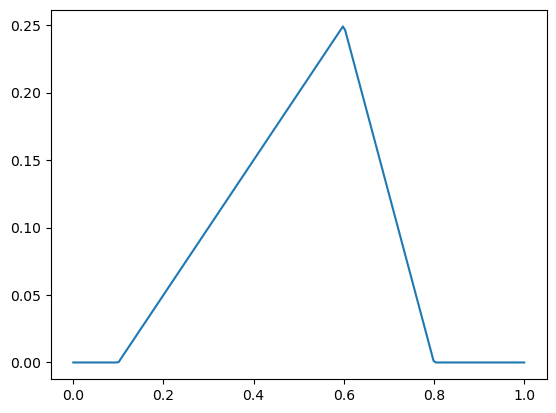

In [2]:
x = np.linspace(0,1,200)
y = x.copy()
y[x < 0.1] = 0
# add gradient of +0.5 if x> 0.1
y[x >= 0.1] = 0.5*(x[x >= 0.1]- 0.1) 
# add negative gradient between 0.6-0.8
y[x>= 0.6] = 0.25 - 0.25/0.2*(x[x>=0.6] - 0.6)
y[x > 0.8] = 0 

fig, ax = plt.subplots()
plt.plot(x,y)

Fit NN

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Set up a sequential NN
model = Sequential()
# add a alayer of 3 ReLU nodes, taking a single parametric input
model.add(Dense(units=3, activation='relu', input_dim=1))
# add a linear node at the end to combine the nodes
model.add(Dense(units=1,activation='linear'))

# Compile model, MSE error, using the Adam algorithm
model.compile(loss="mean_squared_error", optimizer='adam')

# Fit the data, with 200 epochs and batch_size 32
model.fit(x,y,epochs=200, batch_size = 32,verbose=0)

#obtain predictions
y_pred = model.predict(x)

7/7 [==============================] - 0s 4ms/step


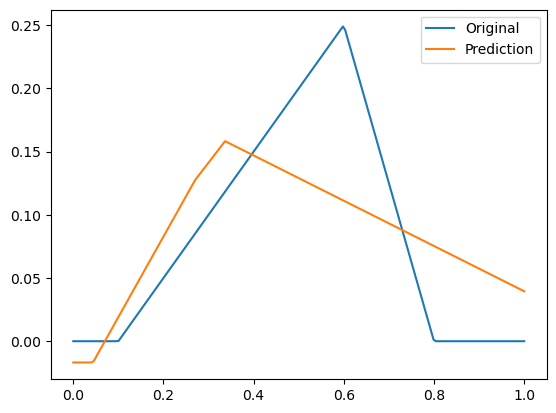

In [4]:
fig, ax = plt.subplots()
plt.plot(x,y,label='Original')
plt.plot(x,y_pred,label='Prediction')
plt.legend()

7/7 [==============================] - 0s 5ms/step


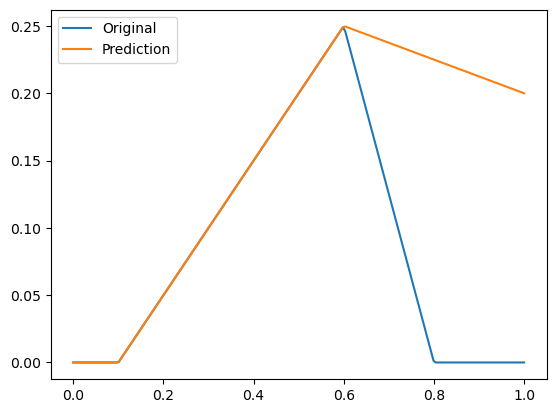

In [5]:
# Manual weights that fit the function
model.layers[0].set_weights([ np.array([[0.5,-(-0.5-0.125), 0.125]],), 
np.array([-0.05, (-0.5-0.125)*0.6, -(0.25/0.2)*0.8],)] )

model.layers[1].set_weights( [ np.array([[1],[-1],[1]]), np.array([0],) ]   )

y_pred = model.predict(x)
fig, ax = plt.subplots()
plt.plot(x,y,label='Original')
plt.plot(x,y_pred,label='Prediction')
plt.legend()

7/7 [==============================] - 0s 2ms/step


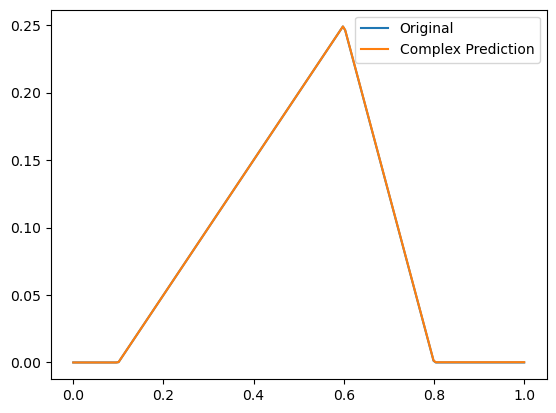

In [6]:
# Try with 150 nodes and 2000 epochs
# Set up a sequential NN
adv_model = Sequential()
adv_model.add(Dense(units=150, activation='relu', input_dim=1))
# add a linear node at the end to combine the nodes
adv_model.add(Dense(units=1,activation='linear'))

adv_model.compile(loss="mean_squared_error", optimizer='adam')
adv_model.fit(x,y,epochs=2000, batch_size = 32, verbose=0)

#obtain predictions
y_pred = adv_model.predict(x)
fig, ax = plt.subplots()
plt.plot(x,y,label='Original')
plt.plot(x,y_pred,label='Complex Prediction')
plt.legend()

Can try softplus, tanh, sigmoid activation functions as well

In [7]:
# Try multiple layers : Hidden layers: 10-10-10, Relu
model = Sequential()
# add a alayer of 3 ReLU nodes, taking a single parametric input
model.add(Dense(units=10, activation='relu', input_dim=1))
model.add(Dense(units=10,activation='relu'))
model.add(Dense(units=10,activation='relu'))
model.add(Dense(units=1,activation='linear')) # Linear node at end
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the data, with 200 epochs and batch_size 32
model.fit(x,y,epochs=2000, batch_size = 32, verbose=0)

7/7 [==============================] - 0s 3ms/step


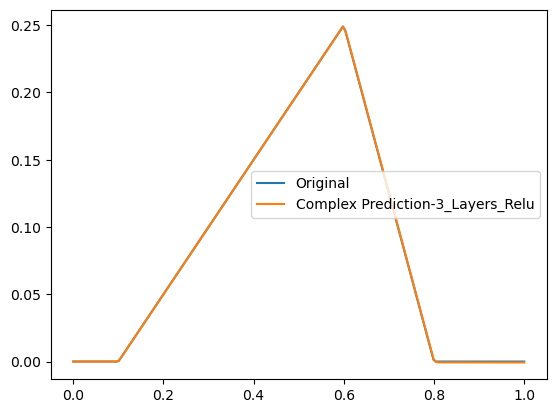

In [8]:
#obtain predictions and plot
y_pred = model.predict(x)
fig, ax = plt.subplots()
plt.plot(x,y,label='Original')
plt.plot(x,y_pred,label='Complex Prediction-3_Layers_Relu')
plt.legend()

7/7 [==============================] - 0s 2ms/step


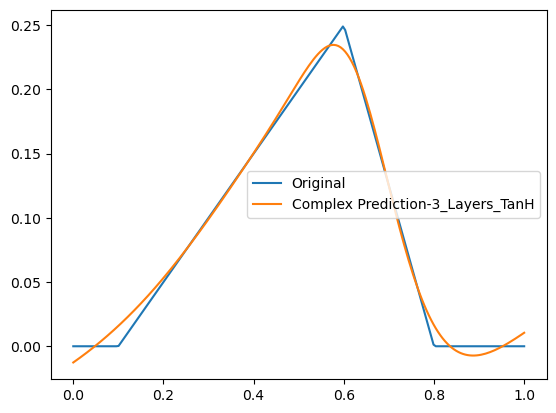

In [9]:
# Try same thing with tanh instead of Relu
model = Sequential()
# add a alayer of 3 ReLU nodes, taking a single parametric input
model.add(Dense(units=10, activation='tanh', input_dim=1))
model.add(Dense(units=10,activation='tanh'))
model.add(Dense(units=10,activation='tanh'))
model.add(Dense(units=1,activation='linear')) # Linear node at end
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x,y,epochs=2000, batch_size = 32, verbose=0)
#obtain predictions and plot
y_pred = model.predict(x)
fig, ax = plt.subplots()
plt.plot(x,y,label='Original')
plt.plot(x,y_pred,label='Complex Prediction-3_Layers_TanH')
plt.legend()

## 2- 2 Parameter Example

In [10]:
def gen_simple_circular_distribution(n=100, scale=1):
    a = np.round(n/3).astype('int')
    b = n-a
    r1 = np.random.normal(loc=0, scale=scale, size=[a, 1])
    r2 = np.random.normal(loc=5, scale=scale, size=[b, 1])

    th1 = np.random.uniform(low=0, high=2 * np.pi, size=[a, 1])
    th2 = np.random.uniform(low=0, high=2 * np.pi, size=[b, 1])

    x1a = r1 * np.cos(th1)
    x2a = r1 * np.sin(th1)

    x1b = r2 * np.cos(th2)
    x2b = r2 * np.sin(th2)

    X = np.concatenate([np.concatenate([x1a.reshape([a, 1]), x1b.reshape([b, 1])]),
                        np.concatenate([x2a.reshape([a, 1]), x2b.reshape([b, 1])])], axis=1)

    y = np.concatenate([np.zeros([a, 1]), np.ones([b, 1])]).squeeze()
    return X, y

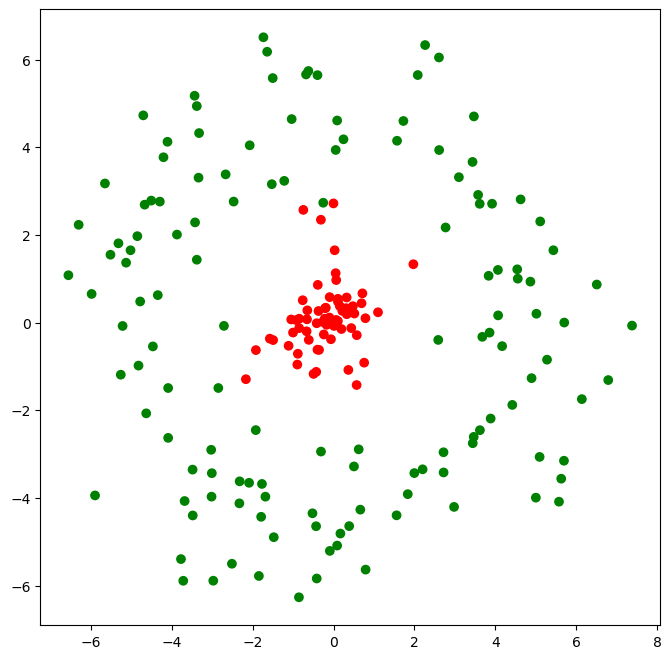

In [12]:
import matplotlib
X,y = gen_simple_circular_distribution(n=200)
fig = plt.figure(figsize=(8,8))
colors=['red','green']
plt.scatter(X[:,0], X[:,1], c=y, cmap=matplotlib.colors.ListedColormap(colors))

In [13]:
#Set up nn
model = Sequential()
model.add(Dense(units=4, activation='relu', input_dim=2))
model.add(Dense(units=4,activation='relu'))
model.add(Dense(units=2,activation='softmax'))
# Final layer has two outputs -probablities for category 1 and 2
# Softmax means outputs sum to one

model.compile(loss="categorical_crossentropy", optimizer='sgd')

from tensorflow.keras.utils import *
y_binary = to_categorical(y)
# use this as the label

model.fit( X,y_binary,epochs=250, batch_size = 32, verbose=0)

In [14]:
# Define grid -10 to 10, sample the space, then plot
def gen_sample_grid(npx=200, npy=200, limit=1):
  x1line = np.linspace(-limit, limit, npx)
  x2line = np.linspace(-limit, limit, npy)
  x1grid, x2grid = np.meshgrid(x1line, x2line)
  Xgrid = np.array([x1grid, x2grid]).reshape([2,npx*npy]).T
  return Xgrid,x1line,x2line

Xgrid,x1line,x2line = gen_sample_grid(200,200,10)

y_pred = model.predict(Xgrid)

1250/1250 [==============================] - 3s 2ms/step


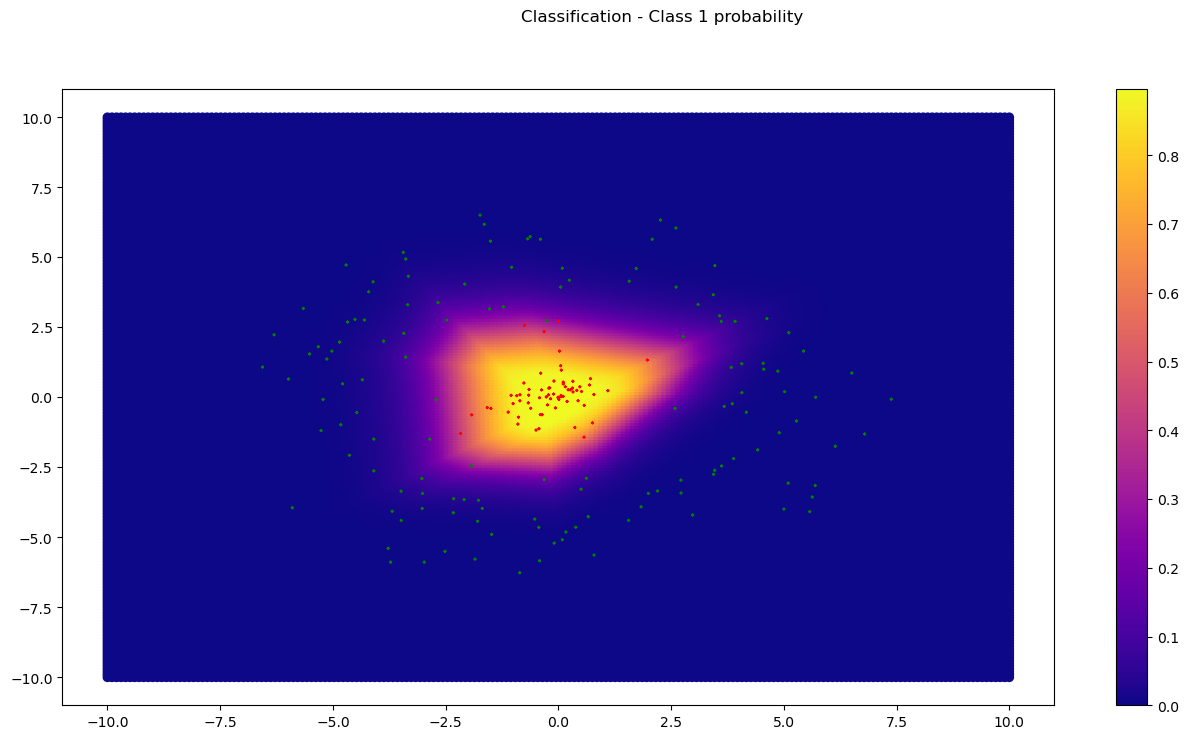

In [15]:
from matplotlib.pyplot import figure
my_fig, ax = plt.subplots()
my_fig.set_size_inches(16, 8, forward=True)
points = ax.scatter(Xgrid[:,0], Xgrid[:,1], c=y_pred[:,0], cmap="plasma")
my_fig.colorbar(points)
my_fig.suptitle('Classification - Class 1 probability')

colors=['red','green']
ax.scatter(X[:,0], X[:,1],c=y, cmap=matplotlib.colors.ListedColormap(colors), marker='x',s=2)

Try:
- Increase and decrease the number of training points
- Try the xor dataset
- Increase and decrease the number of epochs used in training
- Change the neural network itself - reduce and increase the number of layers, change the numbers
of nodes. Try different functions as before; options include
– relu
– softmax
– tanh
– softplus
– sigmoid

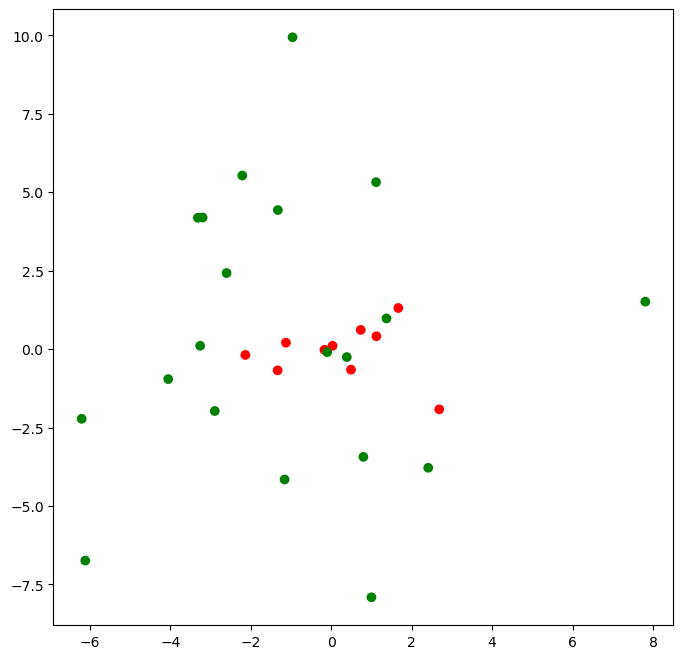

In [16]:
# Do some overfitting
X,y = gen_simple_circular_distribution(n=30,scale=2)
fig = plt.figure(figsize=(8,8))
colors=['red','green']
plt.scatter(X[:,0], X[:,1], c=y, cmap=matplotlib.colors.ListedColormap(colors))

In [17]:
#Set up nn
model = Sequential()
model.add(Dense(units=6, activation='relu', input_dim=2))
model.add(Dense(units=6,activation='relu'))
model.add(Dense(units=6,activation='relu'))
model.add(Dense(units=2,activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer='sgd')

y_binary = to_categorical(y)

model.fit( X,y_binary,epochs=1500, batch_size = 30, verbose=0)
y_pred = model.predict(Xgrid)

1250/1250 [==============================] - 4s 3ms/step


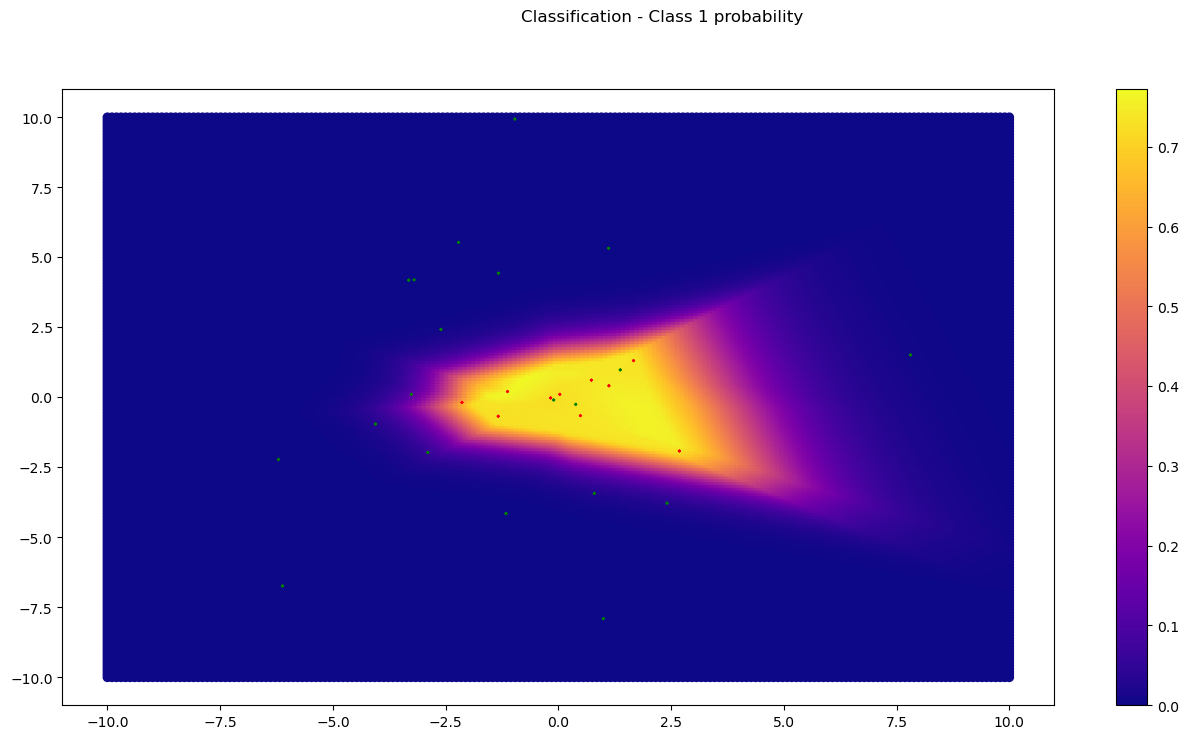

In [18]:
my_fig, ax = plt.subplots()
my_fig.set_size_inches(16, 8, forward=True)
points = ax.scatter(Xgrid[:,0], Xgrid[:,1], c=y_pred[:,0], cmap="plasma")
my_fig.colorbar(points)
my_fig.suptitle('Classification - Class 1 probability')

colors=['red','green']
ax.scatter(X[:,0], X[:,1],c=y, cmap=matplotlib.colors.ListedColormap(colors), marker='x',s=2)

In [19]:
# Check if the GPU is being used
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [21]:
model.save("model.h5")

4. Ring Distribution - Optional

Given functions

In [22]:
import numpy as np


def get_cov(sdx=1., sdy=1., rotangdeg=0.):
    covar = np.array([[sdx, 0], [0, sdy]])
    rot_ang = rotangdeg / 360 * 2 * np.pi
    rot_mat = np.array([[np.cos(rot_ang), -np.sin(rot_ang)], [np.sin(rot_ang), np.cos(rot_ang)]])

    covar = np.matmul(np.matmul(rot_mat, covar), rot_mat.transpose())
    return covar


def gen_circular_distribution(n=500, scale=1):
    a = np.round(n / 7).astype('int')
    b = np.round(2*n / 7).astype('int')
    c = n - a - b
    r1 = np.concatenate(
        [np.random.normal(loc=2, scale=scale, size=[a, 1]), np.random.normal(loc=8, scale=scale, size=[c, 1])])
    r2 = np.random.normal(loc=5, scale=scale, size=[b, 1])

    th1 = np.random.uniform(low=0, high=2 * np.pi, size=[a+c, 1])
    th2 = np.random.uniform(low=0, high=2 * np.pi, size=[b, 1])

    x1a = r1 * np.cos(th1)
    x2a = r1 * np.sin(th1)

    x1b = r2 * np.cos(th2)
    x2b = r2 * np.sin(th2)

    X = np.concatenate([np.concatenate([x1a.reshape([a+c, 1]), x1b.reshape([b, 1])]),
                        np.concatenate([x2a.reshape([a+c, 1]), x2b.reshape([b, 1])])], axis=1)

    y = np.concatenate([np.zeros([a+c, 1]), np.ones([b, 1])]).squeeze()
    return X, y


def gen_simple_circular_distribution(n=100, scale=1):
    a = np.round(n/3).astype('int')
    b = n-a
    r1 = np.random.normal(loc=0, scale=scale, size=[a, 1])
    r2 = np.random.normal(loc=5, scale=scale, size=[b, 1])

    th1 = np.random.uniform(low=0, high=2 * np.pi, size=[a, 1])
    th2 = np.random.uniform(low=0, high=2 * np.pi, size=[b, 1])

    x1a = r1 * np.cos(th1)
    x2a = r1 * np.sin(th1)

    x1b = r2 * np.cos(th2)
    x2b = r2 * np.sin(th2)

    X = np.concatenate([np.concatenate([x1a.reshape([a, 1]), x1b.reshape([b, 1])]),
                        np.concatenate([x2a.reshape([a, 1]), x2b.reshape([b, 1])])], axis=1)

    y = np.concatenate([np.zeros([a, 1]), np.ones([b, 1])]).squeeze()
    return X, y


def gen_xor_distribution(n=100):
    a = np.round(n / 4).astype('int')
    b = n-a*3
    xc1 = np.concatenate([np.random.multivariate_normal([-2.3, -2.3], get_cov(0.4, 0.1, -45), a),
                          np.random.multivariate_normal([2.3, 2.3], get_cov(0.4, 0.1, -45), a)])
    xc2 = np.concatenate([np.random.multivariate_normal([-2.3, 2.3], get_cov(0.4, 0.1, 45), a),
                          np.random.multivariate_normal([2.3, -2.3], get_cov(0.4, 0.1, 45), b)])
    xc = np.array(np.concatenate([xc1, xc2]))

    y = np.array(np.concatenate([np.zeros([2 * a, 1]), np.ones([a+b, 1])])).squeeze()
    X = xc
    return X, y


In [23]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import *

import matplotlib.pyplot as plt

X,y = gen_circular_distribution(500)

model = Sequential()

model.add(Dense(units=6, activation='relu', input_dim=2)) 
model.add(Dense(units=6, activation='relu')) 
model.add(Dense(units=6, activation='relu')) 
model.add(Dense(units=2, activation='softmax')) 

model.compile(loss='categorical_crossentropy',
              optimizer='sgd')


y_binary = to_categorical(y)

model.fit(X, y_binary, epochs=250, batch_size=32)

def gen_sample_grid(npx=200, npy=200, limit=1):
  x1line = np.linspace(-limit, limit, npx)
  x2line = np.linspace(-limit, limit, npy)
  x1grid, x2grid = np.meshgrid(x1line, x2line)
  Xgrid = np.array([x1grid, x2grid]).reshape([2,npx*npy]).T
  return Xgrid,x1line,x2line
lim = 10
Xgrid,x1line,x2line = gen_sample_grid(limit=lim)

out_values = model.predict(Xgrid)

out_grid = np.reshape(out_values[:, 0], [200, 200])

fig, ax = plt.subplots()
plt.contourf(x1line,x2line,out_grid)

ax.scatter(X[y == 0, 0], X[y == 0, 1], marker='x', s=2)
ax.scatter(X[y == 1, 0], X[y == 1, 1], marker='x', s=2)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)


Epoch 1/2500
16/16 [==============================] - 1s 9ms/step - loss: 0.7079
Epoch 2/2500
16/16 [==============================] - 0s 9ms/step - loss: 0.6293
Epoch 3/2500
16/16 [==============================] - 0s 10ms/step - loss: 0.6207
Epoch 4/2500
16/16 [==============================] - 0s 9ms/step - loss: 0.6164
Epoch 5/2500
16/16 [==============================] - 0s 8ms/step - loss: 0.6135
Epoch 6/2500
16/16 [==============================] - 0s 9ms/step - loss: 0.6113
Epoch 7/2500
16/16 [==============================] - 0s 8ms/step - loss: 0.6091
Epoch 8/2500
16/16 [==============================] - 0s 8ms/step - loss: 0.6073
Epoch 9/2500
16/16 [==============================] - 0s 8ms/step - loss: 0.6062
Epoch 10/2500
16/16 [==============================] - 0s 9ms/step - loss: 0.6050
Epoch 11/2500
16/16 [==============================] - 0s 8ms/step - loss: 0.6035
Epoch 12/2500
16/16 [==============================] - 0s 8ms/step - loss: 0.6025
Epoch 13/2500
16/16 [===

KeyboardInterrupt: 